In [78]:
# import libraries
import random
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn

from simplenet_v0 import SimpleNet
from simplenet_v0 import train
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from utilities import set_seed
from utilities import import_data
from utilities import CreateDataset
from utilities import compute_accuracy

In [71]:
# constant
output_size = 1
input_size = 15
seeds = [4650,4660,4670,4680]

# import data
data, _, _ = import_data()

# split data into training set (80%) and testing set (20%) using seed = 3670
train_data, test_data, _, _ = train_test_split(data, data.iloc[:,0], test_size=0.2, random_state=3670)

In [88]:
# validate a specific hyperparameter
def validator(data, hidden_size=50, num_epoch=500, batch_size=10, learning_rate=0.001, weight_decay=1e-5, momemtum=None):
    data = np.array(data)
    input_size = data.shape[1] - 1
    MSEs = []
    MSEs_train = []
    accs = []
    criterion = nn.MSELoss()
    criterion = nn.L1Loss()
    
    for seed in seeds:
        set_seed(seed) # set a seed
        kf = KFold(n_splits=10, shuffle=True, random_state=seed) # split data
        fold_count = 1
        
        for train_index, val_index in kf.split(data):
            # obtain training and validation set
            data_train, data_val = data[train_index], data[val_index]
            
            # set up train dataloader
            train_dataset = CreateDataset(data_train)
            train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            
            # initialise network
            simple_nn = SimpleNet(input_size, hidden_size, output_size)
            
            # define optimiser
            if momemtum == None:
                optimiser = torch.optim.Adam(simple_nn.parameters(), lr=learning_rate, weight_decay=weight_decay)
            else:
                optimiser = torch.optim.SGD(simple_nn.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momemtum)

            # train the model
            train(simple_nn, train_loader, num_epoch, optimiser)
            
            # set to evaluation mode
            simple_nn.eval()
            
            # compute train loss (comment out to speed up)
            # inputs = torch.Tensor(data_train[:, 1:]).float()
            # targets = torch.Tensor(data_train[:, 0]).float()
            # outputs = simple_nn(inputs)
            # MSE_train = criterion(outputs, targets).item()
            MSE_train = 0
            MSEs_train.append(MSE_train)
            
            # compute validation loss
            inputs = torch.Tensor(data_val[:, 1:]).float()
            targets = torch.Tensor(data_val[:, 0]).float()
            outputs = simple_nn(inputs)
            MSE = criterion(outputs, targets).item()
            MSEs.append(MSE)
            
            # compute validation acc
            accs.append(compute_accuracy(outputs, targets, 1))
            
            print(f'Seed: {seed}   Fold: {fold_count}/10   val_MSE: {MSE:.4f}   train_MSE {MSE_train:.4f}', end = '\r')
            fold_count += 1
            
    return MSEs, np.mean(MSEs), np.std(MSEs), MSEs_train, accs

### Find the best hyperparameters

In [25]:
hypers = {'hidden_sizes': [5, 50, 100, 1000],
          'batch_sizes': [1, 5, 10, 30],
          'num_epochs': [100, 200, 500, 1000],
          'learning_rates': [0.01, 0.001, 0.0001]}

defaults = {'hidden_sizes': 50,
            'batch_sizes': 10,
            'num_epochs': 500,
            'learning_rates': 0.001}

In [23]:
# Adam or SGD
results1 = validator(data, hidden_size=50, num_epoch=500, batch_size=10, learning_rate=0.001, weight_decay=1e-5, momemtum=None)
print()
print(results1[1], results1[2])

Seed: 4680   Fold: 10/10   val_MSE: 1.9997   train_MSE 1.1544
1.96382132768631 0.4618585915208865


In [24]:
# Adam or SGD
results2 = validator(data, hidden_size=50, num_epoch=500, batch_size=10, learning_rate=0.001, weight_decay=1e-5, momemtum=0.9)
print()
print(results2[1], results2[2])

Seed: 4680   Fold: 10/10   val_MSE: 1.7991   train_MSE 1.1486
2.1208101242780684 0.44660277002891663


#### Find the best hidden size

In [26]:
hidden_sizes = [5, 50, 100, 1000]
scores1 = []

for hidden_size in hidden_sizes:
    _, score, _, _, _ = validator(train_data, hidden_size=hidden_size)
    scores1.append(score)

In [28]:
best_candidate = hidden_sizes[np.argmin(scores1)]
print(f'Candidates = {hidden_sizes}')
print(f'Scores = {scores1}')
print(f'Best Candidate: {best_candidate}')

Candidates = [5, 50, 100, 1000]
Scores = [1.9591217041015625, 2.061592608690262, 2.1242285072803497, 2.510769861936569]
Best Candidate: 5


#### Find the best batch size

In [33]:
batch_sizes = [1, 5, 10, 30] # result of batch_sizes = 10 is already obtained
scores2 = []

for batch_size in batch_sizes:
    _, score, _, _, _ = validator(train_data, hidden_size=5, batch_size=batch_size)
    scores2.append(score)

In [34]:
best_candidate = batch_sizes[np.argmin(scores2)]
print(f'Candidates = {batch_sizes}')
print(f'Scores = {scores2}')
print(f'Best Candidate: {best_candidate}')

Candidates = [1, 5, 10, 30]
Scores = [2.2346859693527223, 2.0165548771619797, 1.9591217041015625, 2.0120023280382155]
Best Candidate: 10


#### Find the best epoch number

In [39]:
num_epochs = [100, 200, 500, 1000]
scores3 = []

for num_epoch in num_epochs:
    _, score, _, _, _ = validator(train_data, hidden_size=5, num_epoch=num_epoch, batch_size=10)
    scores3.append(score)

In [40]:
best_candidate = num_epochs[np.argmin(scores3)]
print(f'Candidates = {num_epochs}')
print(f'Scores = {scores3}')
print(f'Best Candidate: {best_candidate}')

Candidates = [100, 200, 500, 1000]
Scores = [1.998982799053192, 2.004741036891937, 1.9591217041015625, 2.0820351421833037]
Best Candidate: 500


#### Find the best learning rate

In [67]:
learning_rates = [0.1, 0.01, 0.001, 0.0001]
scores4 = []

for learning_rate in learning_rates:
    _, score, _, _, _ = validator(train_data, hidden_size=5, num_epoch=500, batch_size=10, learning_rate=learning_rate)
    scores4.append(score)

In [68]:
best_candidate = learning_rates[np.argmin(scores4)]
print(f'Candidates = {learning_rates}')
print(f'Scores = {scores4}')
print(f'Best Candidate: {best_candidate}')

Candidates = [0.1, 0.01, 0.001, 0.0001]
Scores = [2.9866421818733215, 2.844581151008606, 1.992581158876419, 4.057089066505432]
Best Candidate: 0.001


#### Find weight decay

In [72]:
decays = [1e-5,1e-4,1e-3,1e-1]
scores5 = []

for decay in decays:
    _, score, _, _, _ = validator(train_data, hidden_size=5, num_epoch=500, batch_size=10, learning_rate=0.001, weight_decay=decay)
    scores5.append(score)

In [73]:
best_candidate = decays[np.argmin(scores5)]
print(f'Candidates = {decays}')
print(f'Scores = {scores5}')
print(f'Best Candidate: {best_candidate}')

Candidates = [1e-05, 0.0001, 0.001, 0.1]
Scores = [1.9591217041015625, 1.9588386297225953, 1.9563440680503845, 1.9836634039878844]
Best Candidate: 0.001


### Benchmark the final model on 80 random testing-training split and model initialisation

In [76]:
seeds = [1130,1013,1005,1101,1140,1218,1600,1014]
scores = validator(data, hidden_size=5, num_epoch=500, batch_size=10, learning_rate=0.001, weight_decay=0.001)

Mean: 1.893686167895794
Median: 1.8239777088165283
Standard Deviation: 0.441994251084627

Mean: 70.38995726495727
Median: 69.23076923076923
Standard Deviation: 7.820329363529906


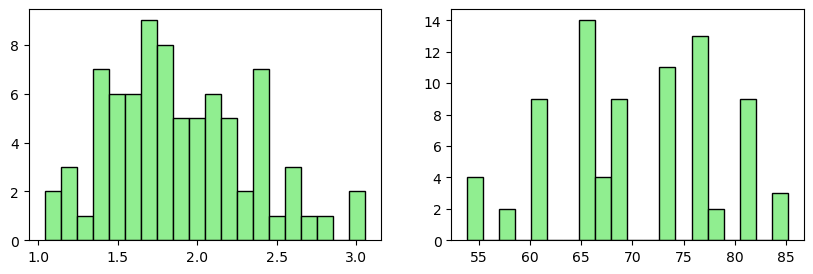

In [77]:
np.save('results/simple_net_MSE.npy', scores[0])
np.save('results/simple_net_acc.npy', scores[4])
MSEs = np.load('results/simple_net_MSE.npy')
accs = np.load('results/simple_net_acc.npy')

print(f'Mean: {np.mean(MSEs)}')
print(f'Median: {np.median(MSEs)}')
print(f'Standard Deviation: {np.std(MSEs)}')
print()
print(f'Mean: {np.mean(accs)}')
print(f'Median: {np.median(accs)}')
print(f'Standard Deviation: {np.std(accs)}')

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.hist(MSEs, color='lightgreen', ec='black', bins=20)
plt.subplot(1,2,2)
plt.hist(accs, color='lightgreen', ec='black', bins=20)
plt.show()

In [ ]:
#### Visualise the dataset

In [5]:
data_reduced = pd.read_csv('data/snippets_reduced.csv')

Mean: 51.378205128205124   Accuracy: 50.0000 %
Median: 51.85185185185185
Standard Deviation: 9.427729226697634


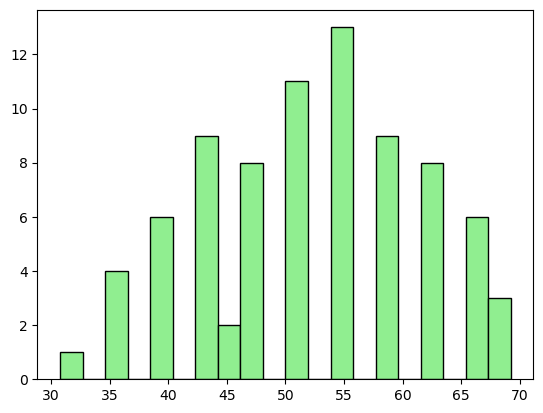

In [10]:
seeds = [1130,1013,1005,1101,1140,1218,1600,1014]
scores = validator(data_reduced, hidden_size=1000, num_epoch=500, batch_size=5, learning_rate=0.001, average_scores=False)

np.save('results/simple_net_benchmark_reduced.npy', scores)
scores = np.load('results/simple_net_benchmark_reduced.npy')

print(f'Mean: {np.mean(scores)}')
print(f'Median: {np.median(scores)}')
print(f'Standard Deviation: {np.std(scores)}')

# print the distribution
plt.hist(scores, color='lightgreen', ec='black', bins=20)
plt.show()

In [61]:
from scipy.sparse import issparse
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.spatial.distance import cosine
from sklearn.decomposition import (
    PCA,
    TruncatedSVD,
)

# This function is modified from COMP4650 Assignment 2
# It is written by teathers
def visualise_clusters(X, clusters, title=None, fout=None, sample_size=1000):
    """Visualising the clustering.

    Args:
        X: A matrix of features of documents. Each row represents a document.
        clusters (np.ndarray): The index of cluster each document belongs to, e.g., clusters[i] = k
            denotes that the i-th document is in the k-th cluster.
        title (str): Optional. The title of the figure.
        fout (str): Optional. The output figure filename.
    """

    if X.shape[0] > sample_size:
        idx = np.random.choice(X.shape[0], sample_size, replace=False)
        X = X[idx]
        clusters = clusters[idx]

    print('Reducing dimensionality ...')
    #dim = 23
    # if isinstance(X, np.ndarray):
    #     Z = PCA(n_components=dim).fit_transform(X) if X.shape[1] > dim else X
        

    t_sne = TSNE(metric=cosine, init='pca', random_state=100)
    
    Z = t_sne.fit_transform(X)

    print('Visualising clusters ...')
    points_colour = clusters
    fig = plt.figure(figsize=(5, 5))
    plt.scatter(Z[:, 0], Z[:, 1], c=points_colour, s=20, alpha=0.9)
    # remove ticks and tick labels
    plt.tick_params(bottom=False, labelbottom=False,
                    top=False, labeltop=False,
                    left=False, labelleft=False,
                    right=False, labelright=False)
    plt.title(title, size=14)
    if fout is not None:
        plt.savefig(fout, bbox_inches='tight')
    plt.show()
    
visualise_clusters(np.array(data.iloc[:,1:]),np.array(data.iloc[:,0]))

Reducing dimensionality ...
Visualising clusters ...


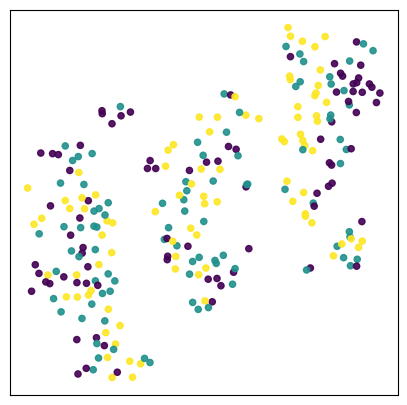

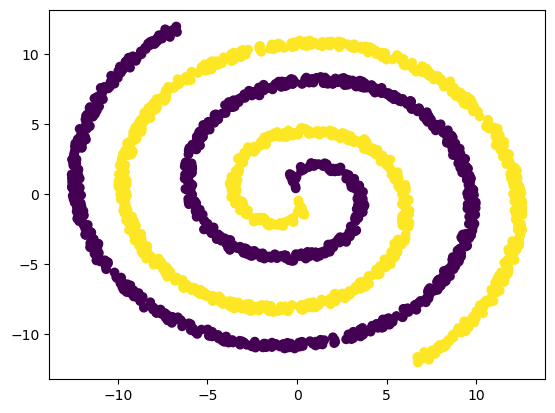

In [63]:
def generate_two_spirals(n_points, noise=.5):
    n = np.sqrt(np.random.rand(n_points, 1)) * 780 * (2 * np.pi) / 360
    d1x = -np.cos(n) * n + np.random.rand(n_points, 1) * noise
    d1y = np.sin(n) * n + np.random.rand(n_points, 1) * noise
    return (np.vstack((np.hstack((d1x, d1y)), np.hstack((-d1x, -d1y)))),
            np.hstack((np.zeros(n_points), np.ones(n_points))))

X, labels = generate_two_spirals(1000)

data_spiral = pd.DataFrame({'0': labels, '1': X[:, 0], '2': X[:, 1]})
plt.scatter(X[:,0], X[:,1], c=labels)

51.378205128205124 9.427729226697634 50.0000 %


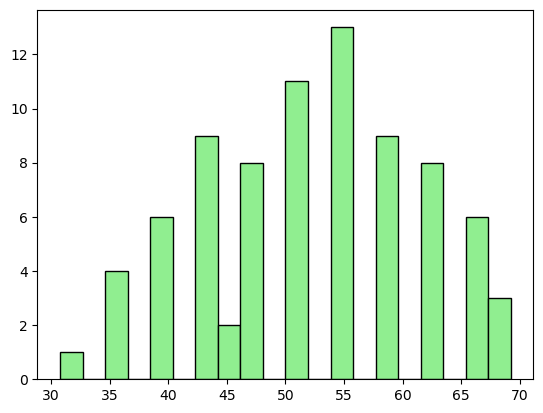

In [64]:
seeds = [1130,1013,1005,1101,1140,1218,1600,1014]
scores_spiral = validator(data_reduced, hidden_size=1000, num_epoch=500, batch_size=5, learning_rate=0.001, average_scores=False)

print(np.mean(scores_spiral),np.std(scores_spiral))

# print the distribution
plt.hist(scores_spiral, color='lightgreen', ec='black', bins=20)
plt.show()

In [83]:
MSEs_sim = np.load('results/simple_net_MSE.npy')
MSEs_cas = np.load('results/casper_MSE.npy')

In [85]:
import scipy.stats as stats
t_stat, p_value = stats.ttest_ind(MSEs_sim, MSEs_cas)
print(t_stat, p_value)

-0.574714675449036 0.5663016937934854


### L1 Loss

In [89]:
seeds = [1130,1013,1005,1101,1140,1218,1600,1014]
scores = validator(data, hidden_size=5, num_epoch=500, batch_size=10, learning_rate=0.001, weight_decay=0.001)

Mean: 1.1245527118444443
Median: 1.101607084274292
Standard Deviation: 0.14212670950626627

Mean: 70.38995726495727
Median: 69.23076923076923
Standard Deviation: 7.820329363529906


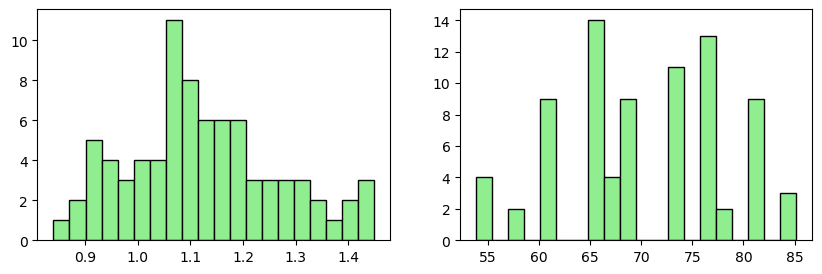

In [90]:
np.save('results/simple_net_MSE_L1.npy', scores[0])
np.save('results/simple_net_acc_L1.npy', scores[4])
MSEs = np.load('results/simple_net_MSE_L1.npy')
accs = np.load('results/simple_net_acc_L1.npy')

print(f'Mean: {np.mean(MSEs)}')
print(f'Median: {np.median(MSEs)}')
print(f'Standard Deviation: {np.std(MSEs)}')
print()
print(f'Mean: {np.mean(accs)}')
print(f'Median: {np.median(accs)}')
print(f'Standard Deviation: {np.std(accs)}')

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.hist(MSEs, color='lightgreen', ec='black', bins=20)
plt.subplot(1,2,2)
plt.hist(accs, color='lightgreen', ec='black', bins=20)
plt.show()

In [92]:
np.min(MSEs)

0.8398497700691223